# Part 2: Identifying Where to Search

## Objective: 
Construct asset groups to target for volatility analysis and arbitrage opportunities.

## Approaches:
**Group Construction:** Group assets based on industry sectors, market capitalization, and other relevant factors (e.g., S&P 500 sectors). Utilize clustering algorithms to identify natural groupings within the asset universe.

**Correlation Analysis:** Perform correlation analysis to understand relationships between assets within and across groups.

**Network Analysis:** Build a network map of assets to visualize and analyze interconnections.

## Task
**Implement a basic clustering analysis algorithm (K-means) on a short time span of Yahoo Finance S&P 500 data.**



In [1]:
# !pip install yfinance
# !pip install pandas
# !pip install numpy 
# !pip install matplotlib
# !pip install scipy
# !pip install statsmodels
# !pip install arch
# !pip install scikit-learn
# !pip install community
# !pip install networkx
# !pip install python-louvain
# !pip install dash jupyter-dash

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
from community import community_louvain
import matplotlib.patches as mpatches
from statsmodels.tsa.stattools import coint


from scipy.cluster.hierarchy import dendrogram, linkage


In [3]:
# Color settings
pink_colors = [
    '#FFC0CB', '#FFB6C1', '#D8BFD8', '#DDA0DD', '#EE82EE', 
    '#DA70D6', '#FF69B4', '#FF1493', '#DB7093', '#C71585'
]
cmap = ListedColormap(pink_colors)

soft_pink = '#FFF1FF'
vivid_pink = '#FCC5FB'
deep_pink = '#FF69B4'
purple = '#FCF1FF'
light_purple = '#FFF9FF'
plum = '#5B095B'

# yass
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'Avenir', 
    'axes.facecolor': light_purple,
    'axes.edgecolor': vivid_pink,
    'axes.labelcolor': vivid_pink,
    'xtick.color': deep_pink,
    'ytick.color': deep_pink,
    'text.color': plum,
    'legend.facecolor': soft_pink,
    'legend.edgecolor': vivid_pink,
    'figure.facecolor': light_purple  
})

### Step 1:  Market Chameleon Characteristics Data
Import and join datasets of S&P 500 features


In [4]:
mc_data_1 = pd.read_csv('MC Data/Market Chameleon S&P 500 Characteristics.csv')
mc_data_2 = pd.read_csv('MC Data/Market Chameleon S&P 500 Characteristics 2.csv')

mc_data_2['Symbol'] = mc_data_2['Symbol'].astype(str)
mc_data = pd.concat([mc_data_1, mc_data_2], axis=1)

#remove duplicate columns
mc_data = mc_data.loc[:,~mc_data.columns.duplicated()]
sp500list = mc_data["Symbol"].tolist()

print (len(sp500list))

503


### Step 2: Preprocess and Join Data

**Data Cleaning:**
Clean and preprocess the downloaded data, handling missing values and ensuring all data points are aligned by date.


In [5]:
mc_data.ffill(inplace=True)
scaler = StandardScaler()

# Adjust the feature list to only include available columns
numeric_features = [
    'Price', 'Volume', 'Avg. Volume', 'Relative Volume', 'Market Cap', 'Dividend Yield', 
    'P/E', 'Std Dev.1', 'Sharpe Ratio', 'Avg Ret.1', 'Std Dev.2', 'Sharpe Ratio.1', 
    'Avg Ret.2', 'Std Dev.3', 'Sharpe Ratio.2',     '% Chg', '% Chg From Open', 
    '% From 20-Day MA', '% From 250-Day MA', '% From 50-Day MA', '% From 52-Week High', 
    '% From 52-Week Low', '% Open Jump', '% Pos', '% Pos.1', '% Pos.2',
    '1-Yr % Chg', '2-Day % Chg', '2-Week % Chg', '3-Day % Chg', '3-Month % Chg', '3-Yr % Chg',
    '4-Day % Chg', '5-Day % Chg', '5-Yr % Chg', '6-Day % Chg', '6-Month % Chg', '7-Day % Chg',
    'YTD % Chg', '20-Day MA', '20-Day MA vs 250-Day MA', '20-Day MA vs 50-Day MA', '50-Day MA',
    '50-Day MA vs 250-Day MA', 'Day VWAP', 'Day VWAP Resistance', 'Day VWAP Support',
    '1-Day OHLC Volatility', '1-Year OHLC Volatility', '14-Day RSI', '20-Day OHLC Volatility',
    'Capital Expenditure Annual Growth (5yr)', 'Cash Return', 'Current Ratio', 'Debt/Assets',
    'Debt/Capital', 'Debt/Cash', 'Debt/Ebitda', 'Debt/Equity', 'Diluted EPS Growth (3yr)',
    'Dividend Decreases 3-Year', 'Dividend Growth 1-Year', 'Dividend Growth 3-Yr Avg',
    'Dividend Increases 3-Year', 'EV to Ebitda', 'Ebit Margin', 'Ebitda Margin', 'Effective Tax Rate',
    'Financial Leverage', 'Forward P/E', 'Gross Margin', 'Gross Profit Annual Growth (5yr)',
    'Interest Coverage', 'Net Income Growth (5yr)', 'Net Profit Margin', 'Normalized Net Profit Margin',
    'Operating Income Growth (5yr)', 'Operation Margin', 'P/E Normalized EPS', 'P/E.1', 'PEG Pay Back',
    'PEG Ratio', 'Payout Ratio', 'Pre-Tax Margin', 'Price/Book Value', 'Price/CFO', 'Price/Cash',
    'Price/Ebitda', 'Price/Free Cash Flow', 'Price/Sales', 'Price/Tangible Book Value', 'Quick Ratio',
    'ROA', 'ROIC', 'Return on Equity', 'Revenue Growth (5yr)', 'Sales Per Employee', 'Share Float',
    'Shares Outstanding', 'Std Dev', 'Sustainable Growth', 'Avg Ret', 'IV % Rank', 'IV30', 'IV30 % Chg',
    'Option Volume', 'Price vs. VWAP  (Pct Chg)', 'Price vs. VWAP  (Std Devs)', 'Relative Option Volume'
]

# Identify categorical features in the dataset
categorical_features = mc_data.select_dtypes(include=['object']).columns
additional_categorical_features = [
    'Country', 'Earnings Type', 'In ETFs', 'Industry', 'Moving Avg Indicator', 'Name', 'Sector',
    'Stock Ideas', 'Stock Type', 'Symbol', 'Volatility Skew Indicator', '1 Day Support/Resistance'
]

# Display categorical features
categorical_features.tolist()

categorical_features = categorical_features.union(additional_categorical_features)

# Filter the dataset to only include these features
mc_data_filtered = mc_data[numeric_features].copy()

# Handle missing values by filling them with the mean of each column
mc_data_filtered.fillna(mc_data_filtered.mean(), inplace=True)

# Normalize the data
data_normalized = scaler.fit_transform(mc_data_filtered)

# One-hot encode categorical features
data_onehot = pd.get_dummies(mc_data[categorical_features])

# Combine the one-hot encoded features with the normalized numerical features
data_combined = pd.concat([data_onehot, pd.DataFrame(data_normalized, columns=numeric_features)], axis=1)



### Step 3: Apply K-means clustering

**Apply K-means Clustering:** Apply the K-means clustering algorithm to the normalized data to identify natural groupings of assets.

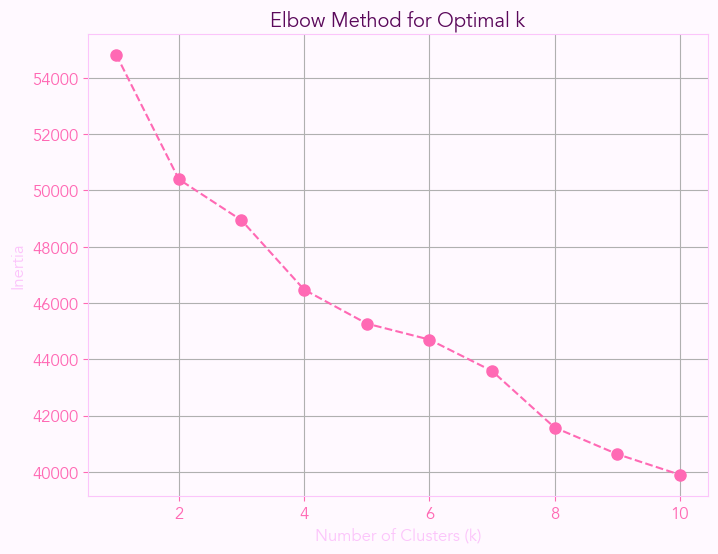

In [6]:
# Perform k-means clustering with k=4 on the combined data
kmeans_combined = KMeans(n_clusters=8, random_state=42)
clusters_combined = kmeans_combined.fit_predict(data_combined)

# Determine the optimal number of clusters using the Elbow method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
# Scale this plot correctly to show the elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o', color=deep_pink, markersize=8, linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

### Step 4: Cluster Analysis
**Normalize Data:** Sector Distribution in Each Cluster

In [7]:
# Perform k-means clustering with k=4 on the fully combined data
kmeans_final = KMeans(n_clusters=4, random_state=42)
clusters_final = kmeans_final.fit_predict(data_combined)

mc_data['Cluster_Final'] = clusters_final

# Group the dataset by the final cluster labels
clustered_equities = mc_data.groupby('Cluster_Final')[['Symbol', 'Name']].apply(lambda x: x.values.tolist())

# Convert the grouped data to a dictionary for easier readability
clustered_equities_dict = clustered_equities.to_dict()

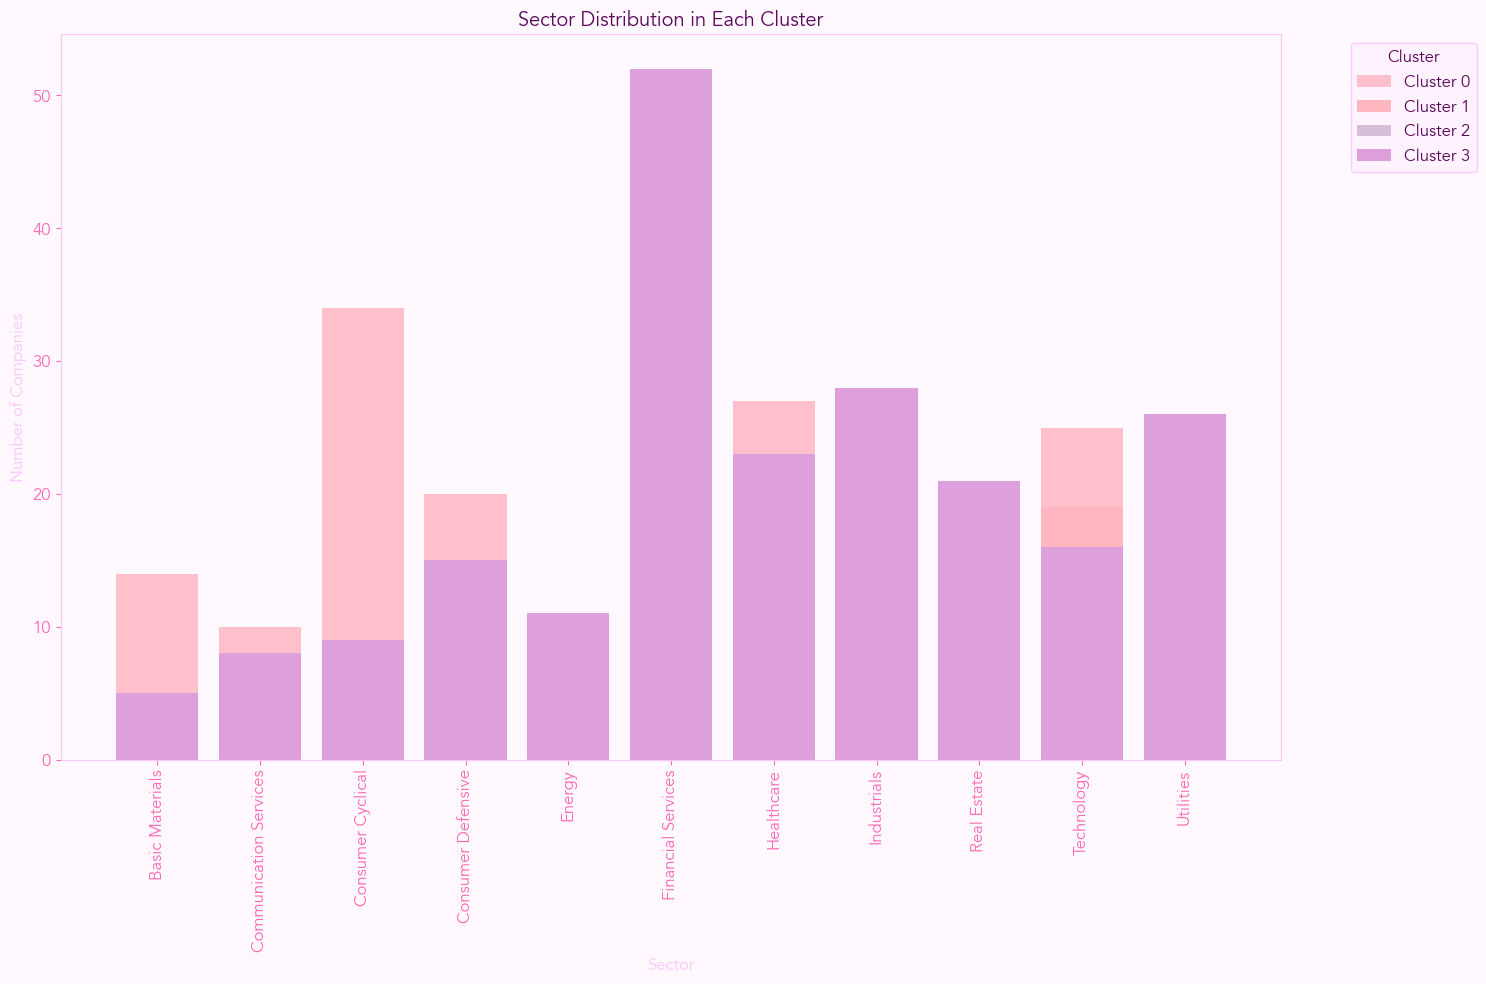

In [8]:
# Create a dataframe with the relevant information for plotting
plot_data = mc_data[['Cluster_Final', 'Sector']].copy()
plot_data['Count'] = 1

# Group by cluster and sector, then count the occurrences
sector_counts = plot_data.groupby(['Cluster_Final', 'Sector']).count().reset_index()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Get unique clusters and sectors
clusters = sector_counts['Cluster_Final'].unique()
sectors = sector_counts['Sector'].unique()

# Plot the data
for i, cluster in enumerate(clusters):
    cluster_data = sector_counts[sector_counts['Cluster_Final'] == cluster]
    ax.bar(cluster_data['Sector'], cluster_data['Count'], label=f'Cluster {cluster}', color=cmap(i))

# Add labels and title
ax.set_xlabel('Sector')
ax.set_ylabel('Number of Companies')
ax.set_title('Sector Distribution in Each Cluster')
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


## Step 5: Louvain Community Detection

Apply Fruchterman-Reingold force-directed algorithm

**Plot 1** Communities Detected in the S&P 500 Dataset Colored in by Weighted Similarity

**Plot 2** Communities Detected in the S&P 500 Dataset Colored in by Sector


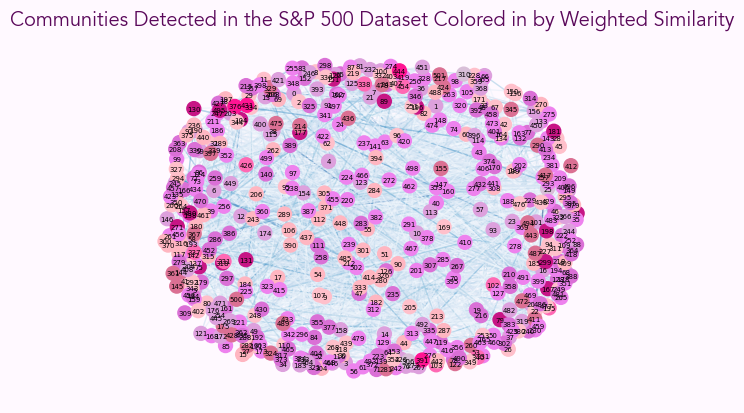

<Figure size 2000x2000 with 0 Axes>

In [9]:
# Create a similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(data_normalized)

# Construct the graph
G = nx.Graph()

# Add nodes (companies)
for idx, row in mc_data.iterrows():
    G.add_node(idx, label=row['Symbol'])  # Add node with label as company symbol

# Add edges (similarities)
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.5:  # Add edge if similarity is above a threshold
            G.add_edge(i, j, weight=similarity_matrix[i, j])  # Add edge with weight as similarity

# Apply the Louvain method to detect communities
partition = community_louvain.best_partition(G, weight='weight')  # Detect communities based on edge weight

# Add community information to the data
mc_data['Community'] = mc_data.index.map(partition)  # Map community information to original data

# Visualize the communities
pos = nx.spring_layout(G, k=0.5, iterations=20)  # Position nodes using Fruchterman-Reingold force-directed algorithm

# Draw the nodes with color based on community
nodes = nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, cmap=cmap, node_color=list(partition.values()))

# Draw the edges with color based on weight
edges = nx.draw_networkx_edges(G, pos, edge_cmap=plt.cm.Blues, edge_color=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.5)

# Draw the labels with decreased font size for better visibility
labels = nx.draw_networkx_labels(G, pos, font_size=5)  # Decrease font size

# Set a title
plt.title('Communities Detected in the S&P 500 Dataset Colored in by Weighted Similarity') 

# Remove the axis
plt.axis('off')

# Increase figure size for better visibility
plt.figure(figsize=(20, 20))

# Display the graph
plt.show()

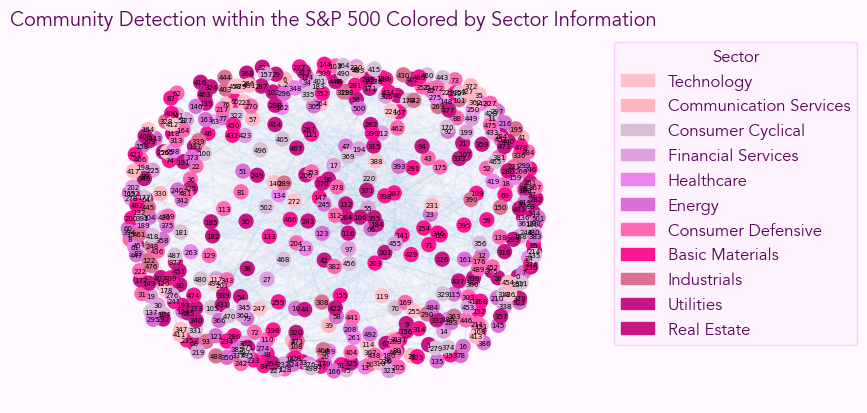

<Figure size 2000x2000 with 0 Axes>

In [10]:
# Create a similarity matrix using cosine similarity
similarity_matrix = cosine_similarity(data_normalized)

# Construct the graph
G = nx.Graph()

# Add nodes (companies)
for idx, row in mc_data.iterrows():
    G.add_node(idx, label=row['Symbol'])  # Add node with label as company symbol

# Add edges (similarities)
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.5:  # Add edge if similarity is above a threshold
            G.add_edge(i, j, weight=similarity_matrix[i, j])  # Add edge with weight as similarity

# Apply the Louvain method to detect communities
partition = community_louvain.best_partition(G, weight='weight')  # Detect communities based on edge weight

# Add community information to the data
mc_data['Community'] = mc_data.index.map(partition)

# Visualize the communities
pos = nx.spring_layout(G, k=0.5, iterations=20)  # Increase k for more spread

sector_list = mc_data['Sector'].unique()
sector_to_color = dict(zip(sector_list, cmap(range(len(sector_list)))))

# Draw the edges with color coding based on weight
edges = nx.draw_networkx_edges(G, pos, edge_cmap=plt.cm.Blues, edge_color=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.1)


# Draw the nodes
nodes = nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, cmap=cmap, node_color=list(mc_data['Sector'].astype('category').cat.codes))


# Draw the labels with decreased font size for better visibility
labels = nx.draw_networkx_labels(G, pos, font_size=5)  # Decrease font size

# Set a title
plt.title('Community Detection within the S&P 500 Colored by Sector Information')

# Create a legend
patches = [mpatches.Patch(color=color, label=sector) for sector, color in sector_to_color.items()]
plt.legend(handles=patches, title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove the axis
plt.axis('off')

# Display the graph
plt.figure(figsize=(20, 20))  # Increase figure size for better visibility
plt.show()

## Step 6: Isolating the most connected subgraphs

**Methodology**
1. We create a graph `G` using the NetworkX library.

2. We add nodes to the graph, with each node representing a company. We use the index of the row in the `mc_data` DataFrame as the node ID and store the 'Symbol' column value as a node attribute.

3. We add edges between nodes (companies) based on a similarity matrix. If the similarity between two companies exceeds 0.5, we create an edge between them, with the similarity value as the edge weight.

4. We calculate the degree (number of connections) for each node.

5. We determine a threshold to identify the most connected nodes (top 10%).

6. We create a subgraph from the most connected nodes.

7. We apply the Louvain method for community detection to the subgraph to identify communities of nodes.

8. We visualize the communities in the subgraph using NetworkX and matplotlib. We color each node according to its community and color edges based on their weight (similarity value).


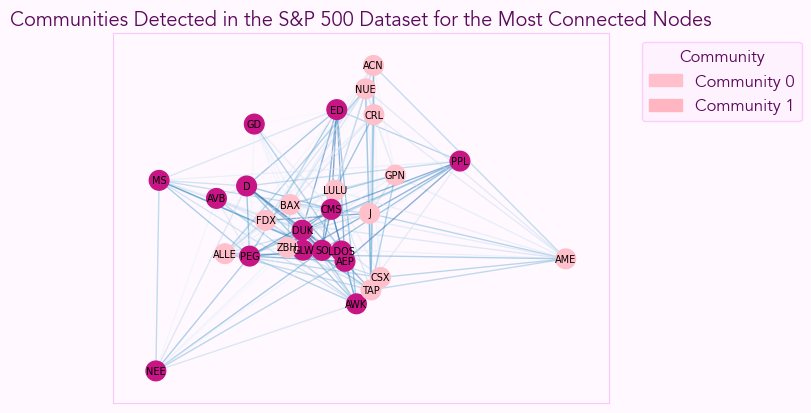

In [11]:
# Construct the graph
G = nx.Graph()

# Add nodes (companies)
for idx, row in mc_data.iterrows():
    G.add_node(idx, label=row['Symbol'])

# Add edges (similarities)
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.5:  # Add edge if similarity is above a threshold
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Calculate degree for each node
degrees = dict(G.degree())

# Find the threshold for the most connected nodes (top 10%)
threshold = np.percentile(list(degrees.values()), 95)

# Get the most connected nodes
most_connected_nodes = [node for node, degree in degrees.items() if degree >= threshold]

# Create subgraph of the most connected nodes
subgraph = G.subgraph(most_connected_nodes)

# Apply the Louvain method to detect communities in the subgraph
partition = community_louvain.best_partition(subgraph, weight='weight')

# Visualize the communities in the subgraph
# Ensure 'labels' dictionary contains all node labels for the subgraph
labels = {node: G.nodes[node]['label'] for node in subgraph.nodes()}

# Draw edges
edge_colors = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues, alpha=0.5)

# Draw nodes
node_colors = list(partition.values())
nx.draw_networkx_nodes(subgraph, pos, node_size=200, cmap=cmap, node_color=node_colors)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=7)


# Create a title
plt.title('Communities Detected in the S&P 500 Dataset for the Most Connected Nodes')

# Create a legend
patches = [mpatches.Patch(color=cmap(i), label=f"Community {i}") for i in range(max(partition.values()) + 1)]
plt.legend(handles=patches, title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

**Analyzing the largest connected components within most connected subgraph**

1. We create a graph `G` using NetworkX.

2. We add nodes representing companies, using the index of `mc_data` as node IDs and the 'Symbol' column as a node attribute.

3. We add edges between nodes based on a similarity matrix, with edges created for similarities above 0.5.

4. We calculate the degree for each node and identify the top 10% most connected nodes.

5. We create a subgraph from these most connected nodes and find all connected components, sorting them by size.

6. We extract the two largest connected components and apply the Louvain method for community detection.

7. We visualize these communities using NetworkX and matplotlib, coloring nodes by community and edges by similarity.


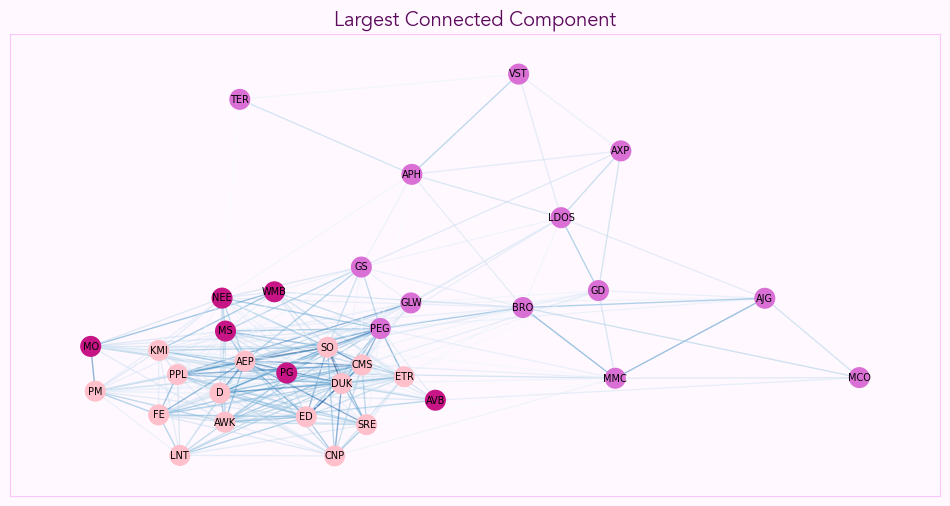

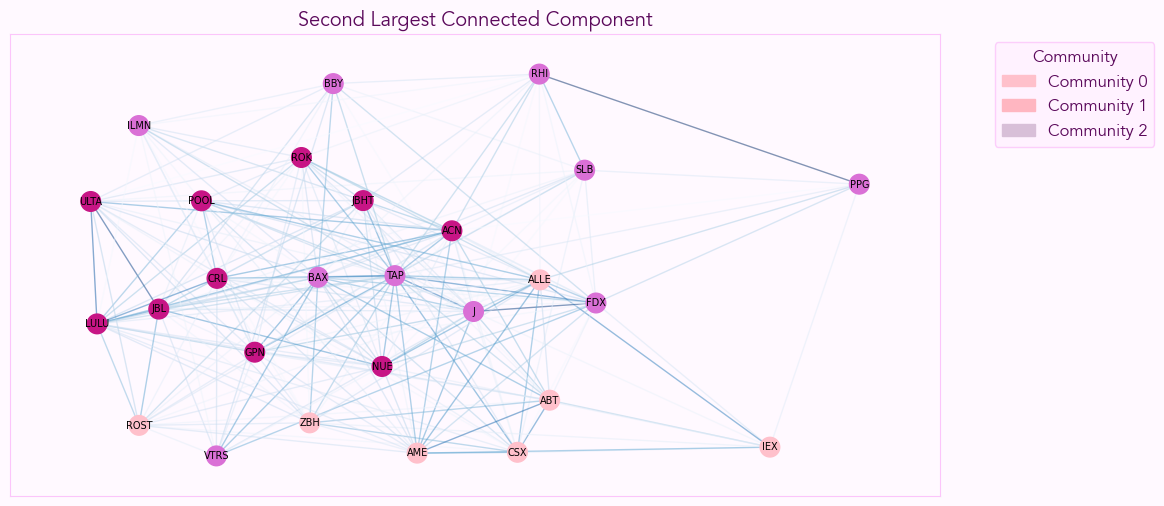

In [12]:
# Construct the graph
G = nx.Graph()

# Add nodes (companies)
for idx, row in mc_data.iterrows():
    G.add_node(idx, label=row['Symbol'])

# Add edges (similarities)
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > 0.5:  # Add edge if similarity is above a threshold
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Calculate degree for each node
degrees = dict(G.degree())

# Find the threshold for the most connected nodes (top 10%)
threshold = np.percentile(list(degrees.values()), 90)

# Get the most connected nodes
most_connected_nodes = [node for node, degree in degrees.items() if degree >= threshold]

# Create subgraph of the most connected nodes
subgraph = G.subgraph(most_connected_nodes)

# Find all connected components in the subgraph
connected_components = list(nx.connected_components(subgraph))

# Sort connected components by size (descending)
connected_components = sorted(connected_components, key=len, reverse=True)

# Extract the two largest connected components
largest_component = subgraph.subgraph(connected_components[0])
second_largest_component = subgraph.subgraph(connected_components[1])

# Apply the Louvain method to detect communities in the largest connected component
partition_largest = community_louvain.best_partition(largest_component, weight='weight')

# Apply the Louvain method to detect communities in the second largest connected component
partition_second_largest = community_louvain.best_partition(second_largest_component, weight='weight')


# Visualize the largest connected component
plt.figure(figsize=(12, 6))
pos_largest = nx.spring_layout(largest_component)
labels_largest = {node: G.nodes[node]['label'] for node in largest_component.nodes()}

# Draw edges
nx.draw_networkx_edges(largest_component, pos_largest, edge_color=[largest_component[u][v]['weight'] for u, v in largest_component.edges()], edge_cmap=plt.cm.Blues, alpha=0.5)

# Draw nodes
nx.draw_networkx_nodes(largest_component, pos_largest, node_size=200, cmap=cmap, node_color=list(partition_largest.values()))

# Draw labels
nx.draw_networkx_labels(largest_component, pos_largest, labels=labels_largest, font_size=7)

plt.title("Largest Connected Component")
plt.show()

# Visualize the second largest connected component
plt.figure(figsize=(12, 6))
pos_second_largest = nx.spring_layout(second_largest_component)
labels_second_largest = {node: G.nodes[node]['label'] for node in second_largest_component.nodes()}

# Draw edges
nx.draw_networkx_edges(second_largest_component, pos_second_largest, edge_color=[second_largest_component[u][v]['weight'] for u, v in second_largest_component.edges()], edge_cmap=plt.cm.Blues, alpha=0.5)

# Draw nodes
nx.draw_networkx_nodes(second_largest_component, pos_second_largest, node_size=200, cmap=cmap, node_color=list(partition_second_largest.values()))

# Draw labels
nx.draw_networkx_labels(second_largest_component, pos_second_largest, labels=labels_second_largest, font_size=7)

patches = [mpatches.Patch(color=cmap(i), label=f"Community {i}") for i in range(max(partition_second_largest.values()) + 1)]
plt.legend(handles=patches, title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Second Largest Connected Component")
plt.show()


## Step 7: Cointegration Analysis of Largest Component

The purpose of this analysis is to identify groups of companies that are closely related based on the chosen similarity measure. In the context of stock market analysis, companies within the same cluster might exhibit similar stock price movements. 

This is a starting point to address cointegration, since we have identified clusters of similar companies, you could then perform a pairwise cointegration test on the stock prices of companies within the same cluster to identify pairs of stocks that are cointegrated. This could be useful in pairs trading strategies, where you go long on one stock and short on another in a cointegrated pair, betting on the convergence of their price difference.

[*********************100%%**********************]  34 of 34 completed


Significant cointegrated pairs: [('AEP', 'AWK'), ('AEP', 'ETR'), ('AEP', 'NEE'), ('AJG', 'MMC'), ('AWK', 'BRO'), ('AWK', 'CMS'), ('AWK', 'CNP'), ('AWK', 'D'), ('AWK', 'DUK'), ('AWK', 'ETR'), ('AWK', 'FE'), ('AWK', 'GD'), ('AWK', 'GLW'), ('AWK', 'LNT'), ('AWK', 'MMC'), ('AWK', 'MO'), ('AWK', 'NEE'), ('AWK', 'PM'), ('AWK', 'PPL'), ('AWK', 'SRE'), ('AWK', 'VST'), ('AWK', 'WMB'), ('AXP', 'MCO'), ('AXP', 'TER'), ('BRO', 'MCO'), ('CNP', 'LDOS'), ('CNP', 'MCO'), ('CNP', 'NEE'), ('CNP', 'PPL'), ('CNP', 'SRE'), ('CNP', 'TER'), ('ED', 'GLW'), ('ED', 'GS'), ('ED', 'MCO'), ('ED', 'MS'), ('ED', 'PG'), ('ED', 'TER'), ('ETR', 'MMC'), ('ETR', 'SRE'), ('FE', 'MO'), ('GLW', 'NEE'), ('GLW', 'TER'), ('KMI', 'LDOS'), ('KMI', 'LNT'), ('KMI', 'MCO'), ('KMI', 'MMC'), ('KMI', 'MO'), ('KMI', 'MS'), ('KMI', 'NEE'), ('KMI', 'PEG'), ('KMI', 'PG'), ('KMI', 'PM'), ('KMI', 'PPL'), ('KMI', 'SO'), ('KMI', 'SRE'), ('KMI', 'TER'), ('KMI', 'VST'), ('KMI', 'WMB'), ('MO', 'TER'), ('MS', 'PM'), ('NEE', 'VST'), ('PEG', 'TER')

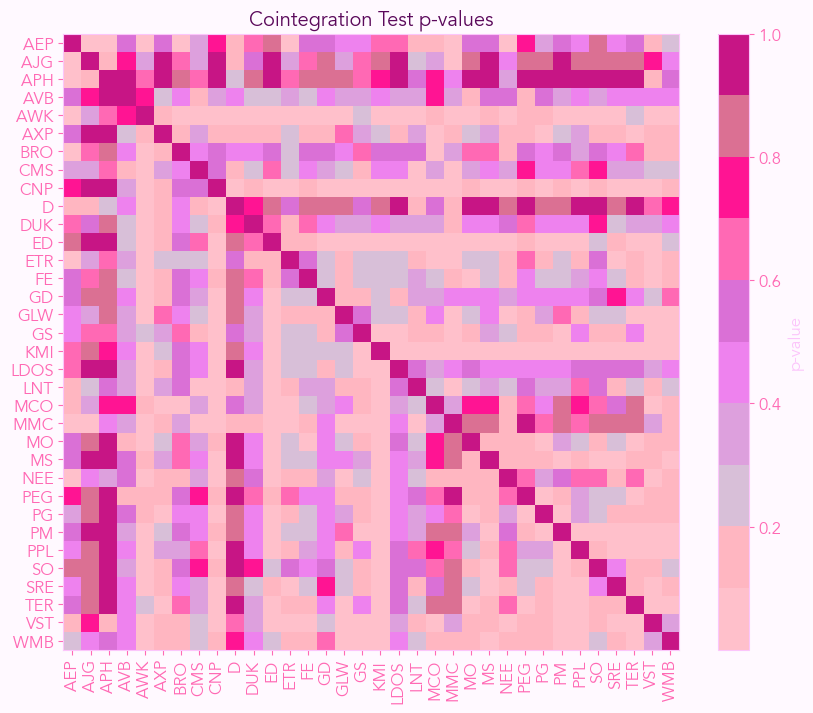

In [18]:

#create a dataframe of the largest connected component's cosine similarity matrix
largest_component_similarity_matrix = cosine_similarity(data_normalized[largest_component.nodes()])


labels_largest = [G.nodes[node]['label'] for node in largest_component.nodes()]
largest_component_similarity_df = pd.DataFrame(largest_component_similarity_matrix, index=labels_largest, columns=labels_largest)


# Step 1: Fetch stock prices data from Yahoo Finance
def fetch_stock_prices(symbols, start_date, end_date):
    data = yf.download(symbols, start=start_date, end=end_date)
    return data['Adj Close']

# Example stock symbols in a cluster
symbols = list(largest_component_similarity_df.columns)
start_date, end_date = '2022-01-01', '2024-01-01'
stock_prices = fetch_stock_prices(symbols, start_date, end_date)

# Step 2: Define a function to perform pairwise cointegration test
def pairwise_cointegration_test(stock_prices):
    n = stock_prices.shape[1]
    p_value_matrix = pd.DataFrame(np.ones((n, n)), columns=stock_prices.columns, index=stock_prices.columns)

    for i in range(n):
        for j in range(i+1, n):
            stock1 = stock_prices.iloc[:, i]
            stock2 = stock_prices.iloc[:, j]
            score, p_value, _ = coint(stock1, stock2)
            p_value_matrix.iloc[i, j] = p_value
            p_value_matrix.iloc[j, i] = p_value

    return p_value_matrix

# Step 3: Apply the function to the stock prices DataFrame
p_value_matrix = pairwise_cointegration_test(stock_prices)

# Step 4: Identify pairs with significant cointegration (e.g., p-value < 0.05)
significant_pairs = []
threshold = 0.05
for i in range(p_value_matrix.shape[0]):
    for j in range(i+1, p_value_matrix.shape[1]):
        if p_value_matrix.iloc[i, j] < threshold:
            significant_pairs.append((p_value_matrix.index[i], p_value_matrix.columns[j]))

print("Significant cointegrated pairs:", significant_pairs)

# Step 5: Visualize the p-value matrix as a heatmap using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(p_value_matrix, cmap=cmap, interpolation='none')
plt.colorbar(label='p-value')
plt.xticks(range(len(p_value_matrix)), p_value_matrix.columns, rotation=90)
plt.yticks(range(len(p_value_matrix)), p_value_matrix.index)
plt.title('Cointegration Test p-values')
plt.show()

# Step 6: Visualize the time series of significantly cointegrated pairs using matplotlib
# make a 34* 34 grid of plots 
# for pair in significant_pairs:
#     plt.figure(figsize=(14, 7))
#     stock_prices[list(pair)].plot( linewidth=2, color = [deep_pink, plum])
#     plt.title(f'Stock Prices of Cointegrated Pair: {pair}')
#     plt.xlabel('Date')
#     plt.ylabel('Adjusted Close Price')
#     plt.legend(pair)
#     plt.show()


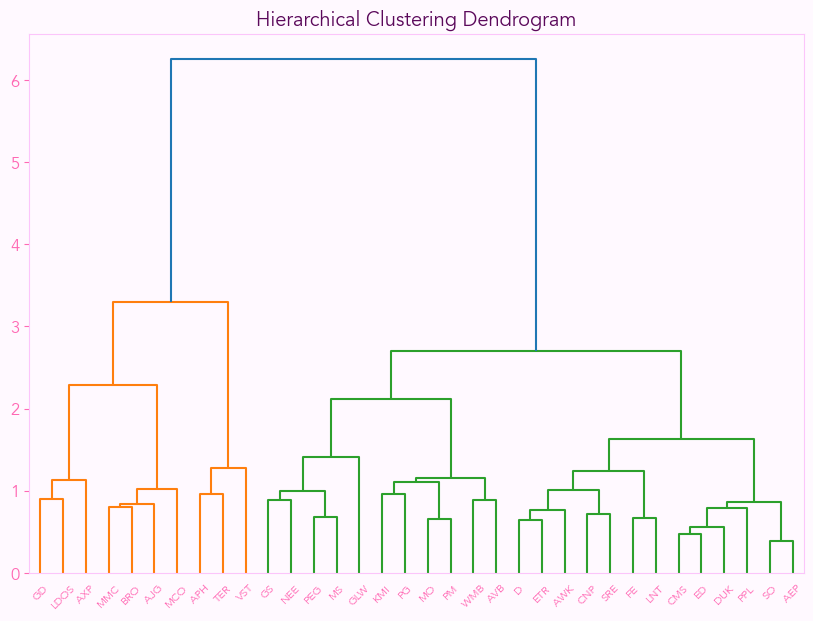

In [19]:
# Perform hierarchical clustering
linked = linkage(largest_component_similarity_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=labels_largest, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [20]:
# Calculate descriptive statistics of the similarity values
similarity_stats = largest_component_similarity_df.describe()



In [21]:
# Calculate centrality measures
betweenness_centrality = nx.betweenness_centrality(largest_component)
closeness_centrality = nx.closeness_centrality(largest_component)
degree_centrality = nx.degree_centrality(largest_component)

# Convert centrality measures to DataFrames for easier analysis
betweenness_df = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betweenness'])
closeness_df = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['closeness'])
degree_df = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree'])

centrality_df = pd.concat([betweenness_df, closeness_df, degree_df], axis=1)
print(centrality_df.sort_values(by='degree', ascending=False).head())

     betweenness  closeness    degree
243     0.084210   0.846154  0.818182
106     0.055057   0.846154  0.818182
112     0.030273   0.804878  0.787879
371     0.026931   0.785714  0.757576
184     0.017124   0.767442  0.727273


contemporaneous
